In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
import torchvision 
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
import itertools

# Parameters Section 

# Data and Dataloader preparing section

In [2]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((128  , 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5 , 0.5 , 0.5) , (0.5 , 0.5 , 0.5))
    ])
dataset = torchvision.datasets.ImageFolder("./dataset/animals" ,transform=TRANSFORM_IMG)

# Model definition

In [3]:
class Generator(nn.Module):
    def __init__(self , input_dims):
        super(Generator, self).__init__()

        self.input_dims = input_dims
        self.input_layer = nn.Linear(input_dims , 4*4*1024)
        self.linear = nn.Linear(4*4*1024 , 4*4*1024)
        self.upscale1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upscale2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upscale3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upscale4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upscale5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
        self.conv1 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

        self.norm2 = nn.LayerNorm((512, 8, 8))
        self.norm3 = nn.LayerNorm((256, 16, 16))
        self.norm4 = nn.LayerNorm((128, 32, 32))
        self.norm5 = nn.LayerNorm((64, 64, 64))


    def forward(self ,z):
        z = self.input_layer(z)
        z = torch.nn.functional.leaky_relu(self.linear(z))
        
        z = z.view(-1 , 1024 , 4 , 4)

        z = self.upscale1(z)
        z = torch.nn.functional.leaky_relu(self.conv1(z)) 
        z = self.norm2(z)

        z = self.upscale2(z)
        z = torch.nn.functional.leaky_relu(self.conv2(z)) 
        z = self.norm3(z)

        z = self.upscale3(z)
        z = torch.nn.functional.leaky_relu(self.conv3(z)) 
        z = self.norm4(z)

        z = self.upscale4(z)
        z = torch.nn.functional.leaky_relu(self.conv4(z)) 
        z = self.norm5(z)

        z = self.upscale5(z)
        z = torch.nn.functional.tanh(z)
        z = self.conv5(z)

        return z


class Critic(nn.Module):
    def __init__(self, output_dims):
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=4, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=4, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=4, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=4, padding=1)

        # self.conv4 = nn.utils.spectral_norm(self.conv4)
        # self.conv3 = nn.utils.spectral_norm(self.conv3)
        # self.conv2 = nn.utils.spectral_norm(self.conv2)
        # self.conv1 = nn.utils.spectral_norm(self.conv1)

        self.linear_intermediate = nn.Linear(512*1*1, 512*1*1)
        self.output_layer = nn.Linear(512*1*1, output_dims)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu((self.conv1(x)))
        x = torch.nn.functional.leaky_relu((self.conv2(x)))
        x = torch.nn.functional.leaky_relu((self.conv3(x)))
        x = torch.nn.functional.leaky_relu((self.conv4(x)))
        # Global Average Pooling
        x = self.linear_intermediate(x.view(x.size(0), -1))
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, features)
        return self.output_layer(x)
    

class DCGan(nn.Module):
    def __init__(self,input_dims =100, output_dims = 1):
        super(DCGan,self).__init__()
        self.gen = Generator(input_dims)
        self.critic = Critic(output_dims)

    def forward(self , latents , images):
        x = self.gen(latents)
        generated = self.critic(x)
        real = self.critic(images) 
        return real , generated

In [24]:
class DCTrainer():
    def __init__(self, model_gen, model_critic, dataloader , optim_gen , optim_critic  , epochs, device ,latent_dims, ngenerate = 5, num_iterations = 10000):
        self.model_gen = model_gen.to(device)
        self.model_critic = model_critic.to(device)
        self.dataloader = dataloader
        self.optim_gen = optim_gen 
        self.optim_critc = optim_critic
        self.epochs = epochs
        self.device = device
        self.ngenerate = ngenerate
        self.latent_dims = latent_dims
        self.num_iterations = num_iterations
        self.lambda_ = 5
        self.mvn = torch.distributions.MultivariateNormal( torch.zeros(latent_dims)  , torch.eye(latent_dims) )
    
    
    def latent_sampler(self ,batch_size ):
        samples = self.mvn.sample((batch_size,))
        return samples
    
    def W_loss_critic(self , real_y, gen_y,):
        real = torch.mean(real_y)
        fake = torch.mean(gen_y)
        return (fake - real) 
    
    def W_loss_gen(self , gen_y):
        return -torch.mean(gen_y)
    
    def noramlize_weights(self ):
        for p in self.model_critic.parameters():
            p.data.clamp_(-1 ,1)

    def gradient_penalty(self , real , fake):
        alpha = torch.rand(real.shape[0], 1, 1, 1).to(self.device)
        interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True) 
        disc_interpolates = self.model_critic(interpolates)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(gradients.size(0), -1)
        penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return penalty

    # def train(self , starting = 0):
    #     for epoch in range(starting , self.epochs):
    #         loss_critic , loss_gen = self.train_step()
    #         print(f"Epoch {epoch} Generator Loss {loss_gen} Critic loss {loss_critic}")
    #         if(epoch%50 == 0):
    #            self.checkpoint(epoch)

    def train(self, starting = 0):
        total_loss_critic = 0
        total_loss_gen = 0
        dataset_iter = itertools.cycle(self.dataloader)
        for i in range(starting, self.num_iterations):

            # Train Critic
            for p in self.model_gen.parameters():
                p.requires_grad = False
            for p in self.model_critic.parameters():
                p.requires_grad = True
                
            for j in range(5):
                i += 1
                self.optim_critc.zero_grad()
                
                data = next(dataset_iter)[0]
                data = data.to(self.device)

                z = self.latent_sampler(data.shape[0]).to(device=self.device)
                gen_data = self.model_gen(z)

                gen_y   = self.model_critic(gen_data) 
                real_y = self.model_critic(data)

                loss_critic = self.W_loss_critic(real_y , gen_y) + self.lambda_ * self.gradient_penalty(data , gen_data)
                total_loss_critic += loss_critic.item()
                loss_critic.backward()
                self.optim_critc.step()

            # Train Generator
            for p in self.model_gen.parameters():
                p.requires_grad = True
            for p in self.model_critic.parameters():
                p.requires_grad = False

            for j in range(5):

                i += 1
                self.optim_gen.zero_grad()
                z = self.latent_sampler(data.shape[0]).to(device=self.device)

                gen_data = self.model_gen(z)
                gen_y = self.model_critic(gen_data)
                loss_gen = torch.mean(gen_y)
                total_loss_gen += loss_gen.item()
                loss_gen.backward()
                self.optim_gen.step()

            if i % 100 == 0:
                print(f"Iteration {i} Generator Loss {loss_gen} Critic loss {loss_critic}")
                self.generate_and_show()
                self.checkpoint(i)
            
        return total_loss_critic/len(self.dataloader) , total_loss_gen/len(self.dataloader)
    
    def show(self , nx = 10 , e = 0 , images = None):
        if(images is None):
            images = self.generate_images(nx)
        images  = [images[i].permute(1,2,0).detach().cpu().numpy() for i in range(images.shape[0])]
        plt.figure(figsize=(3*nx, 2*nx))  # Adjust the size as needed

        # Loop through the images and display each one
        for i, image in enumerate(images):
            plt.subplot(nx//5 + nx%5, 5, i + 1)  # Change '1, 5' to the desired grid layout
            plt.imshow((image * 255).astype(np.uint8))
            plt.axis('off')  # This hides the axis

        plt.show()
        # plt.savefig(f"generated_{e}.png")

    def generate_images(self , number = 5):
        self.model_gen.eval()
        with torch.no_grad():
            z = self.latent_sampler(number).to(device=self.device)
            images = self.model_gen(z)
            return images
        
    def generate_and_show(self , number = 5 , e = 0):
        images = self.generate_images(number)
        self.show(number , e , images)

    def checkpoint(self , iterations):
        torch.save({
            'model_gen_state_dict': self.model_gen.state_dict(),
            'model_critic_state_dict': self.model_critic.state_dict(),
            'optimizer_critic_state_dict': self.optim_critc.state_dict(),
            'optimizer_gen_state_dict' : self.optim_gen.state_dict(),
            'iterations': iterations
        }, f'RMSprop/checkpoint{iterations}.pth')

    def resume(self , path , iterations):
        checkpoint = torch.load(path)
        self.model_gen.load_state_dict(checkpoint['model_gen_state_dict'])
        self.model_critic.load_state_dict(checkpoint['model_critic_state_dict'])
        self.optim_critc.load_state_dict(checkpoint['optimizer_critic_state_dict'])
        self.optim_gen.load_state_dict(checkpoint['optimizer_gen_state_dict'])
        iterations = checkpoint['iterations']+1
        self.num_iterations += iterations
        self.train(iterations)


# Instantiation

In [25]:
batch_size = 256
input_dims = 256
epochs = 1000
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3

dataloader = DataLoader(dataset, batch_size= batch_size, shuffle=True, num_workers=4)

In [26]:
model_critic = Critic(1)
model_gen = Generator(input_dims)

optim_critc = torch.optim.RMSprop(model_critic.parameters() , learning_rate)
optim_gen = torch.optim.RMSprop(model_gen.parameters() , learning_rate)

trainer = DCTrainer(model_gen, model_critic , dataloader , optim_critic=optim_critc, optim_gen=optim_gen , epochs=epochs , device = device , latent_dims=input_dims, num_iterations=5000)

Iteration 100 Generator Loss -807849920.0 Critic loss -365229472.0


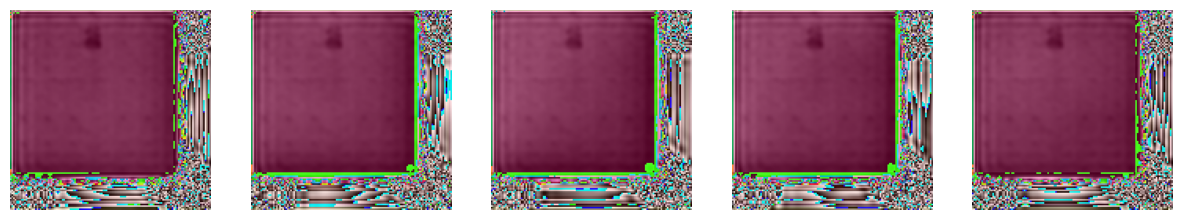

Iteration 200 Generator Loss -2282804736.0 Critic loss -1049519104.0


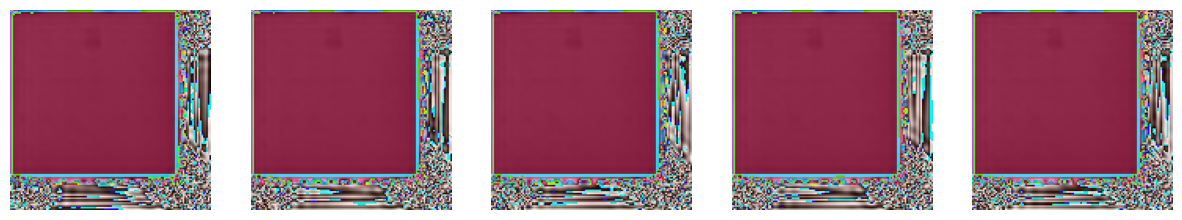

KeyboardInterrupt: 

In [28]:
trainer.train()
# trainer.resume("RMSprop/checkpoint0.pth" , 1000)

In [ ]:
z = torch.randn(5,100)
print(z.shape)

for i in range(0, 125 , 10):
    checkpoint = torch.load(f"RMSprop/checkpoint100.pth" ,  map_location = device)
    model.load_state_dict(checkpoint['model_state_dict'])
    trainer = DCTrainer(model , dataloader , optim_critic=optim_critc, optim_gen=optim_gen , epochs=epochs , device = device , latent_dims=input_dims  ,lambda_=10)
    y = model_gen(z.to(device))
    trainer.show(5 , i , y)
    

In [ ]:
model_gen = torch.load(f"newFolder/model.pt" , map_location=device)
trainer = DCTrainer(model , dataloader , optim_critic=optim_critc, optim_gen=optim_gen , epochs=epochs , device = device , latent_dims=input_dims  ,lambda_=10)
y = model_gen(z.to(device))
trainer.show(5 , 0 , y)
